In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math

import matplotlib.pyplot as plt

# Helper functions for multiple indexes

## Unit conversion

In [2]:
def convert_temp(unit_from, unit_to, temp):

    if(unit_from != unit_to):
        if(unit_to == "K"):
            if(unit_from == "degC"):
                return_temp = temp + 273.15
            elif(unit_from == "degF"):
                return_temp = (temp - 32.0) / 1.8 + 273.15
        elif(unit_to == "degC"):
            if(unit_from == "K"):
                return_temp = temp - 273.15
            elif(unit_from == "degF"):
                return_temp = (temp - 32.0) / 1.8
        elif(unit_to == "degF"):
            if(unit_from == "K"):
                return_temp = (temp - 273.15) * 1.8 + 32.0
            elif(unit_from == "degC"):
                return_temp = temp * 1.8 + 32.0
        else:
            print("The selection of unit", unit_to, "is not recognized. Available options for temperature units are degC, degF, and K")
    else:
            return_temp = temp

    return(return_temp)

def convert_prec(unit_from, unit_to, prec):
    if(unit_from != unit_to):
        if(unit_to == "kg m-2 s-1"):
            if(unit_from == "mm/day"):
                return_pr = prec / 86400.0
            elif(unit_from == "inches/day"):
                return_pr = prec * 24.4 / 86400.0
        elif(unit_to == "mm/day"):
            if(unit_from == "kg m-2 s-1"):
                return_pr = prec * 84600.0
            elif(unit_from == "inches/day"):
                return_pr = prec * 25.4
        elif(unit_to == "inches/day"):
            if(unit_from == "kg m-2 s-1"):
                return_pr = prec * 86400.0 / 25.4
            elif(unit_from == "mm/day"):
                return_pr = prec / 25.4
        elif(unit_to == "inches/hour"):
            if(unit_from == "kg m-2 s-1"):
                return_pr = prec * 3600.0 / 25.4
            elif(unit_from == "mm/day"):
                return_pr = prec / (24. * 25.4)
            elif(unit_from == "inches/day"):
                return_pr = prec / 24.
        else:
            print("the selection of unit", unit_to, "is not recognized. Available options for precipitation units are kg m-2 s-1, mm/day, inches/day, and inches/hour")
    else:
            return_pr = prec
            
    return(return_pr)

def convert_humid(unit_from, unit_to, rh):
    if(unit_from != unit_to):
        if(unit_to == "%"):
            if(unit_from == "1"):
                return_rh = rh * 100.
        elif(unit_to == "1"):
            if(unit_from == "%"):
                return_rh = rh / 100.
        else:
            print("the selection of unit", unit_to, "is not recognized. Available options for humidity units are 1 (unitless) or %")
    else:
        return_rh = rh
    if(unit_to == "1"):
        return_rh = np.clip(return_rh, 0., 1.)
    elif(unit_to == "%"):
        return_rh = np.clip(return_rh, 0., 100.)
        
    return(return_rh)
    
def convert_wind(unit_from, unit_to, wind):
    if(unit_from != unit_to):
        if(unit_to == "m/s" or unit_to == "m s-1"):
            if(unit_from == "mph"):
                return_wind = wind / 2.23694
            elif(unit_from == "kts"):
                return_wind = wind / 1.94386
        elif(unit_to == "mph"):
            if(unit_from == "m/s" or unit_from == "m s-1"):
                return_wind = wind * 2.23694
            elif(unit_from == "kts"):
                return_wind = wind * 1.15078
        elif(unit_to == "kts"):
            if(unit_from == "m/s" or unit_from == "m s-1"):
                return_wind = wind * 1.94386
            elif(unit_from == "mph"):
                return_wind = wind / 1.15078
                
        else:
            print("the selection of unit", unit_to, "is not recognized. Available options for wind units units are m/s, m s-1, kts, and mph")
    else:
        return_wind = wind
    return(return_wind)

## Other functions 

In [3]:
def print_time_error(time_days, acceptable_days):
    time_years = time_days / 365.
    acceptable_years = math.floor(acceptable_days / 365.)
    
    if(time_days < acceptable_days):
        print("Warning: the number of years of data,", str(time_years), "(", str(time_days), "days) is fewer than what is recommended for accuracy.  A minimum of ", str(acceptable_years), "year(s) (",str(math.floor(acceptable_days)), "days) is recommended.")

        
def check_time_length(time_days, acceptable_days, opt):
    if(opt == False):
        print_time_error(time_days, acceptable_days)
    else:
        if(hasattr(opt, "suppressWarning")):
            if(opt.suppressWarning == True):
                print_time_error(time_days, acceptable_days)


def calc_emc(T, H):
    emc = 2.22749 + 0.160107 * H - 0.014784 * T
    #print(T)
    #print(H)
    #print("T.sizes=", T.size)
    emc = np.where(H < 10., 0.03229 + .281073 * H - .000578 * T * H, emc)
    emc = np.where(H > 50., 21.0606 + 0.005565 * (H**2.0) - 0.00035 * H * T - 0.483199 * H, emc)

    return(emc)

# Plot testing function

In [4]:
def test_plot(ref_index, test_index, varname):
    fig, ax = plt.subplots(2, 3, figsize = (20,6))

    for x in range(0,2,1):
        for y in range(0,3,1):
            
            ax[x,y].plot(ref_index.time, ref_index[:, x, y], '--', c = "blue", alpha = .5)
            ax[x,y].plot(test_index.time, test_index[:,x,y], '-', c = "orange", alpha = .5)



# Read in testing files

In [6]:
precfile = 'fire_sample_inputs/prec.gridMET.NAM-22i.20000101-20011231.nc'
tmaxfile = 'fire_sample_inputs/tmax.gridMET.NAM-22i.20000101-20011231.nc'
spdfile = 'fire_sample_inputs/sfcWind.gridMET.NAM-22i.20000101-20011231.nc'
kbdifile = 'fire_sample_inputs/kbdi.gridMET.NAM-22i.20000101-20011231.nc'
hursfile = 'fire_sample_inputs/hurs.gridMET.NAM-22i.20000101-20011231.nc'

prec = xr.open_dataset(precfile)
tmax = xr.open_dataset(tmaxfile)
kbdi_in = xr.open_dataset(kbdifile)
#spd = xr.open_dataset(spdfile)

hursnc = nc.Dataset(hursfile)
spdnc = nc.Dataset(spdfile)

'''spd=xr.DataArray(data=spdnc['spd'][:],
               coords=dict(
                   time=spdnc['time'][:],
                   lat=spdnc['lat'][:],
                   lon=spdnc['lon'][:]
               ),
               attrs=dict(long_name=spdnc['spd'].long_name, units=spdnc['spd'].units)
       )

#spdnc['spd'].units
hurs=xr.Dataset(data_vars=dict(
                hurs=(["time","lat","lon"], hursnc['hurs'][:])
                ),
               coords=dict(
                   time=hursnc['time'][:],
                   lat=hursnc['lat'][:],
                   lon=hursnc['lon'][:]
               ),
               attrs=dict(long_name=hursnc['hurs'].long_name, units=hursnc['hurs'].units)
       )
#kbdi_in'''

spd=xr.DataArray(data=spdnc['spd'][:],
                dims=["time", "lat", "lon"],
               coords=dict(
                   time=spdnc['time'][:],
                   lat=spdnc['lat'][:],
                   lon=spdnc['lon'][:]
               ),
               attrs=dict(long_name=spdnc['spd'].long_name, units=spdnc['spd'].units)
       )
hurs=xr.DataArray(data=hursnc['hurs'][:],
                dims=["time", "lat", "lon"],
               coords=dict(
                   time=hursnc['time'][:],
                   lat=hursnc['lat'][:],
                   lon=hursnc['lon'][:]
               ),
               attrs=dict(long_name=hursnc['hurs'].long_name, units=hursnc['hurs'].units)
       )


# KBDI

## Define function

In [7]:
def calc_kbdi(prec, tmax, calendar, opt):
    """ 
    Calculates Keetch Byram Drought Index. 
        prec is daily precipitation
        tmax is daily maximum temperature
        calendar is the string describing which calendar was used for prec, tmax. 
            Supported calendars: 
                gregorian, standard, 365_day, 366_day, 360_day, no_leap, all_leap
    """
    #Need to add functionality to test if units exist!
    prec_v = convert_prec(prec.units, "inches/day", prec[:])
    tmax_v = convert_temp(tmax.units, "degF", tmax[:])
    
    kbdi_v = prec_v * 0.0
    
    precip_acc = prec_v[0,:,:] * 0.0
    
    Q = kbdi_v[0,:,:] + 100.
    
    total_precip = np.sum(prec_v, axis = 0)
    
    if(calendar == "gregorian" or calendar == "standard"):
        ndaysyear = 365.2425
    elif(calendar == "noleap" or calendar == "365_day"):
        ndaysyear = 365.0
    elif(calendar == "all_leap" or calendar == "366_day"):
        ndaysyear = 366.0
    elif(calendar == "360_day"):
        ndaysyear = 360.0
    else:
        print("calendar not recognized. Proceeding with gregorian/standard calendar.")
        ndaysyear = 365.2425
        
    ndays = len(prec_v[:,0,0])
    nyears = ndays / ndaysyear
    
    check_time_length(ndays, ndaysyear * 30., opt)
    
    annual_pr = total_precip / nyears
    
    for i in range(0,ndays,1):
        precip_d = prec_v[i, :, :]
        maxtemp = tmax_v[i, :, :]
        
        #precip_adj = precip_d * 0.0 # assuming that there was no precipitation the day before calculations started
        precip_acc = np.where(precip_d <= 0.0, 0.0, precip_acc + precip_d)
        precip_adj = np.maximum((precip_acc - 0.2), 0.0) 
        precip_acc = np.clip(precip_acc, 0., 8., out=precip_acc)
        
        #dQ is incremental change in KBDI
        dQ = np.where(maxtemp >= 50.0, (800.0 - Q) * (0.968 * np.exp(0.0486 * maxtemp) - 0.83) / (1. + 10.88 * np.exp(-0.0441 * annual_pr)) * 0.001, 0)
        #dQ is adjusted to 0 when maxtemp < 50 deg F, otherwise is calculated according to KBDI original paper. Adjustment taken from Liu et al.
        
        Q = Q + dQ - (precip_adj * 100) #drought index is reduced 1 point for every .01 inches of adjusted rainfall        
        Q = np.clip(Q, 0, 800)
        
        kbdi_v[i, :, :] = Q

    #Assign metadata and correct structure for return dataset
    kbdi=xr.DataArray(data=kbdi_v,
                    dims=["time", "lat", "lon"],
                   coords=dict(
                       time=prec.time,
                       lat=prec.lat,
                       lon=prec.lon
                   ),
                   attrs=dict(long_name="Keetch Byram Drought Index", units="1")
           )
        
    return(kbdi_v)

## Run test files

In [8]:
#precfile = 'fire_sample_inputs/prec.gridMET.NAM-22i.20000101-20011231.nc'
#tmaxfile = 'fire_sample_inputs/tmax.gridMET.NAM-22i.20000101-20011231.nc'
#prec = xr.open_dataset(precfile)
#tmax = xr.open_dataset(tmaxfile)


In [9]:
#prec.prec
#tmax.tmax

kbdi = calc_kbdi(prec.prec, tmax.tmax, "gregorian", False)

In [10]:
origkbdifile = 'fire_sample_inputs/kbdi.gridMET.NAM-22i.20000101-20011231.ref.nc'
kbdiRef = xr.open_dataset(origkbdifile)

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/anissaz/Desktop/Collaborations/fire-indices/fire_sample_inputs/kbdi.gridMET.NAM-22i.20000101-20011231.ref.nc'

## Test plots

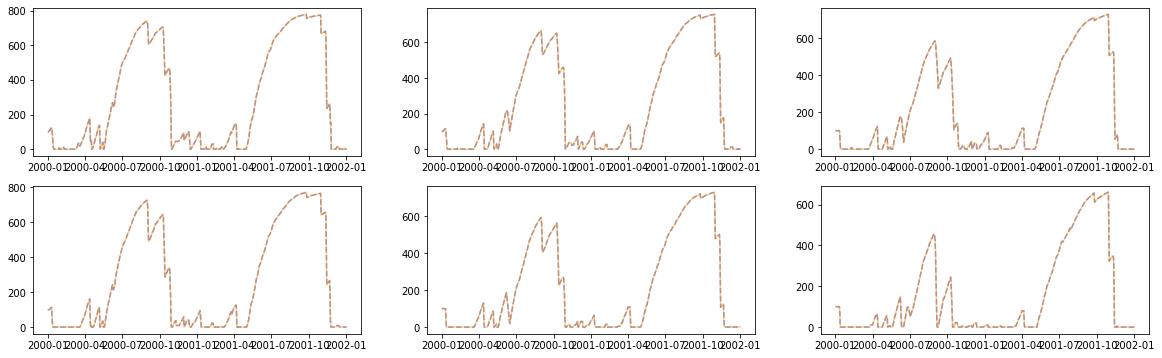

In [42]:
test_plot(kbdiRef.kbdi, kbdi, 'kbdi')

# mFFWI

## Define function

In [45]:
def calc_mffwi(tmax, rh, spd, kbdi):
    rh = convert_humid(rh.units, "%", rh)
    tmax = convert_temp(tmax.units, "degF", tmax)
    spd = convert_wind(spd.units, "mph", spd)
    
    rh_ = rh.data
    tmax_ = tmax.data
    spd_ = spd.data
    kbdi_ = kbdi.data
    
    c1 = 1.0
    c2 = 1.5
    c3 = -0.5
    
    em0 = 0.72
    em = 0.000002
    bf = 1. / 0.3002

    emc = calc_emc(tmax_, rh_) #equilibrium moisture content

    eta = 1 - 2 * (emc / 30) + c2 * ((emc / 30) ** 2) + c3 * ((emc / 30) ** 3)
    FFWI = bf * eta * (1 + (spd_**2.))**0.5
    FAF = em0 + (em * (kbdi_**2.))

    mffwi_v = FAF * FFWI

    mffwi=xr.DataArray(data=mffwi_v,
                dims=["time", "lat", "lon"],
               coords=dict(
                   time=tmax.time,
                   lat=tmax.lat,
                   lon=tmax.lon
               ),
               attrs=dict(long_name="modified Fosberg Fire Weather Index", units="1")
       )

    
    return(mffwi)


## Run test files

In [46]:
mffwi = calc_mffwi(tmax.tmax, hurs, spd, kbdi_in.kbdi)

In [47]:
origmffwifile = 'fire_sample_inputs/mffwi.gridMET.NAM-22i.20000101-20011231.ref.nc'
mffwiRef = xr.open_dataset(origmffwifile)

## Test plots

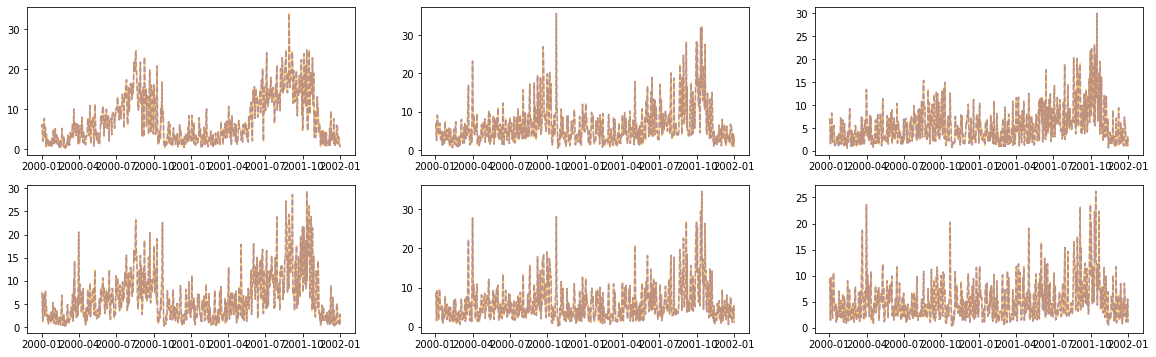

In [48]:
test_plot(mffwiRef.mffwi, mffwi, 'mffwi')

array([[[2.0682156 , 2.6337655 , 2.3036382 ],
        [2.9671366 , 3.3903477 , 3.4121046 ]],

       [[2.3691306 , 1.8665178 , 2.0153368 ],
        [2.587128  , 2.551098  , 2.9428625 ]],

       [[0.6347349 , 0.7571524 , 0.28562173],
        [0.03342012, 0.4451709 , 0.3753794 ]],

       ...,

       [[1.7944484 , 0.72921693, 0.0333786 ],
        [0.2707499 , 1.407244  , 0.71419543]],

       [[0.01221103, 2.2279408 , 1.3968388 ],
        [2.132885  , 2.8139    , 2.5032759 ]],

       [[0.04710501, 0.06113895, 0.05413644],
        [0.06405956, 0.07563914, 0.07192325]]], dtype=float32)